In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch import cuda
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14

In [2]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [3]:
testdir = f"./MHI/data/test"
traindir = f"./MHI/data/train"
validdir = f"./MHI/data/val"

In [4]:
save_file_name = f'alexnet-transfer.pt'
checkpoint_path = f'alexnet-transfer.pth'

# Change to fit hardware
batch_size = 32

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
2 gpus detected.


In [5]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
        # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=0),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=0),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True,num_workers=0)
}

In [7]:
categories = []
for d in os.listdir(traindir):
    categories.append(d)
    
print(categories)
n_classes = len(categories)
print(f'There are {n_classes} different classes.')


['Pushup', 'Squat', 'Lunge', 'Stand', 'Lying']
There are 5 different classes.


In [8]:
class_to_idx = data['train'].class_to_idx
idx_to_class = {
    idx: class_
    for class_, idx in data['train'].class_to_idx.items()
}

In [9]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """
    
    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg', 'resnet', 'inception', 'alexnet', 'squeezenet', 'densenet'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet':
        model = models.resnet34(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']
        
    elif model_name == 'inception':
        model = models.inception_v3(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']
        
    elif model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']
        
    elif model_name == 'squeezenet':
        model = models.squeezenet1_0(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']
        
    elif model_name == 'densenet':
        model = models.densenet169(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']
        
        
    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [10]:
model, optimizer = load_checkpoint(path=checkpoint_path)

57,024,325 total parameters.
54,554,629 total gradient parameters.


In [11]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path).convert('RGB')
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [12]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns
        
    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        #ps = torch.exp(out)
        probabilities = torch.nn.functional.softmax(out[0], dim=0)

        # Find the topk predictions
        topk, topclass = out.topk(topk, dim=1)
        topk, topclass = torch.topk(probabilities, 5)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()
        ]
        top_p = topk.cpu().numpy()
        

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

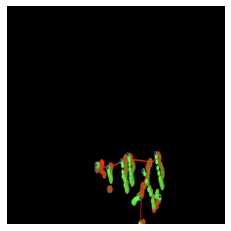

In [13]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(categories)
    root = testdir +"/"+ c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [14]:
img, top_p, top_classes, real_class = predict(random_test_image(), model,topk=2)

In [15]:
top_p, top_classes, real_class

(array([1., 0., 0., 0., 0.], dtype=float32),
 ['Pushup', 'Squat', 'Lunge', 'Stand', 'Lying'],
 'Pushup')

In [16]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)
    #print(result)
    '''max = result.max()
    #print(max)
    min = result.min()
    #print(min)
    k = max - min
    result.at['Stand', 'p'] = (result.at['Stand', 'p'] - min) / k
    print(result.at['Stand', 'p'])
    result.at['Squat', 'p'] = (result.at['Squat', 'p'] - min) / k
    print(result.at['Squat', 'p'])
    result.at['Lunge', 'p'] = (result.at['Lunge', 'p'] - min) / k
    print(result.at['Lunge', 'p'])
    result.at['Lying', 'p'] = (result.at['Lying', 'p'] - min) / k
    print(result.at['Lying', 'p'])
    result.at['Pushup', 'p'] = (result.at['Pushup', 'p'] - min) / k
    print(result.at['Pushup', 'p'])
    #result['p'] = [(result.loc[0, 'p'] - min)/k, (result.loc[1, 'p'] - min)/k, (result.loc[2, 'p'] - min)/k, (result.loc[3, 'p'] - min)/k, (result.loc[4, 'p'] - min)/k]
    print(result)
    all = result.at['Stand', 'p'] + result.at['Squat', 'p'] + result.at['Lunge', 'p'] + result.at['Lying', 'p'] + result.at['Pushup', 'p']
    print(all)
    result.at['Stand', 'p'] = result.at['Stand', 'p'] / all
    print(result.at['Stand', 'p'])
    result.at['Squat', 'p'] = result.at['Squat', 'p'] / all
    print(result.at['Squat', 'p'])
    result.at['Lunge', 'p'] = result.at['Lunge', 'p'] / all
    print(result.at['Lunge', 'p'])
    result.at['Lying', 'p'] = result.at['Lying', 'p'] / all
    print(result.at['Lying', 'p'])
    result.at['Pushup', 'p'] = result.at['Pushup', 'p'] / all
    print(result.at['Pushup', 'p'])
    print(result)'''
    
    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    plt.xlim([0, 1])
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

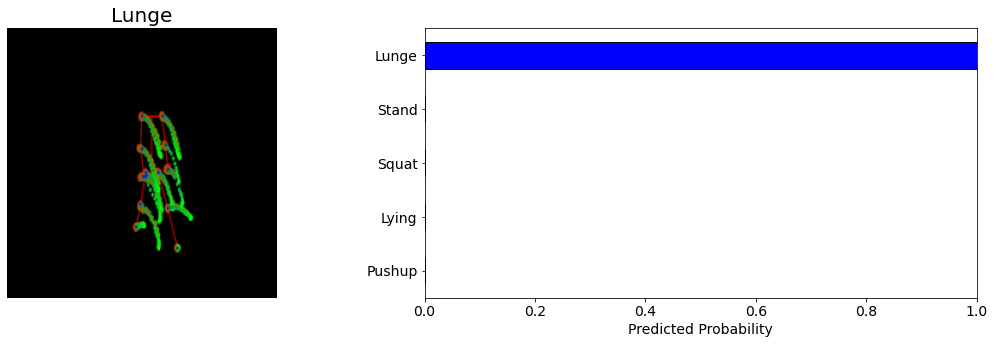

In [112]:
display_prediction(random_test_image(), model, topk=5)

In [102]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [43]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    res = accuracy(model(features.to('cuda')), targets, topk=(1,))
else:
    res = accuracy(model(features), targets, topk=(1, 5))
print(res)

[100.0]
